# Dataset Preparation
This notebook is used to prepare the interpolated dataset for model training. Signals are combined and windowed.
1. Signals are filtered and downsampled(10Hz sample rate and 5Hz Cutoff frequency are used)
2. Signals are split into a train, test and validation split.
3. Signals are windowed to create equal length sub-windows of 12 seconds (input) and 6 seconds (targets)
<br>We create the splits before windowing in order to avoid data leakage.
<br>Notebook '04_Frequency_Analysis' further investigates the filter and sample rates which are used in this notebook.


## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.interpolate import interp1d

# Matplot Setup
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']= 1


In [5]:
imu_params = ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
joints_goal_params = ['position_0', 'position_1']
joints_status_params = ['position_0', 'position_1']

In [6]:
data_path = 'Dataset/Converted_120Hz/'
files = os.listdir(data_path)
files

['2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle',
 '2021-11-26-20-05-14_wobble_interpolated_120Hz.pickle',
 '2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-18-38_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-34-38_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-48-10_wobble_interpolated_120Hz.pickle',
 '2022-01-13-18-02-22_wobble_interpolated_120Hz.pickle',
 '2022-01-20-15-23-37_wobble_interpolated_120Hz.pickle',
 '2022-01-20-15-38-51_wobble_interpolated_120Hz.pickle']

## Load, filter, downsample, clean and combine dictionaries
Load all converted dictionaries with uniform timesteps, clean them based on their indices and combine them to one full dictionary. <br>
Two main functions are created:
1. __butterworth_filter_signal(*args)__: Function to low-pass-filter the signals
2. __downsample_dictionary(*args)__: Filters and downsamples all signals in the dictionary to the desired values

In [7]:
# The filter experiments can be found in notebook 04_Frequency_Analysis
def butterworth_filter_signal(sig, f_cutoff = 10, f_sample = 120, order = 5):
    """filters signal at specified cutoff frequency using a Butterworth filter of specified order
    :param signal: input signal
    :param f_cutoff: Cutoff frequency
    :param f_sample: original sample rate of signal
    :param order: order of the filter
    :return: filtered signal
    """
    w = f_cutoff / (f_sample / 2) # Normalize the frequency must be between 0 < W < 1. 1 = 100% of Nyquist Freq. 0 = 0% of Nyqist Freq
    b,a = scipy.signal.butter(order, w, 'low')
    return scipy.signal.filtfilt(b,a, sig)

In [8]:
def downsample_dictionary(dict_s, sample_rate, f_c = None, order = None):
    """
    Filter and interpolate the 120Hz dictionary to a new sample rate. 
    :param dict_s: signal dicitonary with indices and uniform timesteps
    :param sample_rate: new sample rate
    :param f_c:  Cutoff frequency of low pass flter. If none is specified 0.5*sample_rate is taken
    :param order: Order of lowpass filter. default 5

    :return: Dictionary with filtered and downsampled signals
    """
    interp_fs = dict()
    dict_ds = dict() # downsampled dictionary

    # Load original Timesteps
    orig_t = dict_s['Time']
    duration = orig_t[-1] - orig_t[0]

    orig_n = len(orig_t)
    orig_sr = orig_n / (duration)

    # Collect all parameters to convert
    params_s = []
    for k in dict_s.keys():
        if (k != 'sample_rate') and (k != 'Time') and (k!= 'indices'):
            params_s.append(k)
    
    if not f_c:
        f_c = 0.5*sample_rate
    
    if not order:
        order = 5

    for p in params_s:
        temp_signal = butterworth_filter_signal(dict_s[p], f_cutoff = f_c, f_sample = dict_s['sample_rate'], order= order)
        interp_fs[p] = scipy.interpolate.interp1d(orig_t, temp_signal, fill_value='extrapolate')#.copy()

    # Calculate number of samples, start and end times for new sample rate
    start = dict_s['Time'][0]
    end = dict_s['Time'][-1]
    n_duration = end - start
    n_samples = np.floor(sample_rate*n_duration).astype(int)
    end = n_samples / sample_rate + start

    # Create new uniform Time distribution
    uniform_t = np.linspace(start, end, num = n_samples)

    # Signal Interpolation    
    for p in params_s:
        dict_ds[p] = interp_fs[p](uniform_t)

    # update indices:
    old_sr = dict_s['sample_rate']
    new_indices = []
    for i in dict_s['indices']:
        a = int(i[0]/old_sr*sample_rate)
        b = int(i[1]/old_sr*sample_rate)
        new_indices.append([a,b])
    
    dict_ds['indices'] = new_indices
    dict_ds['Time'] = uniform_t
    dict_ds['sample_rate'] = sample_rate

    # Log information about the process
    s_r = len(uniform_t)/(uniform_t[-1] - uniform_t[0])
    n_samples = len(uniform_t)
    print(f'Converted Signals: {params_s}.')
    print(f'\tBefore: Duration: {duration:.3f}s. Avg Sample Rate: {orig_sr:.3f}/s. Number of samples: {orig_n}.')
    print(f'\tAfter: Duration: {end - start :.3f}s. Avg Sample Rate: {s_r:.3f}/s. Number of samples: {n_samples}. Downsampled by factor {sample_rate/orig_sr:.2f}\n')

    return dict_ds

Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 181.692s. Avg Sample Rate: 120.000/s. Number of samples: 21803.
	After: Duration: 181.600s. Avg Sample Rate: 10.000/s. Number of samples: 1816. Downsampled by factor 0.08

Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 181.692s. Avg Sample Rate: 120.000/s. Number of samples: 21803.
	After: Duration: 181.600s. Avg Sample Rate: 10.000/s. Number of samples: 1816. Downsampled by factor 0.08



Text(0.5, 1.0, 'Original Signal')

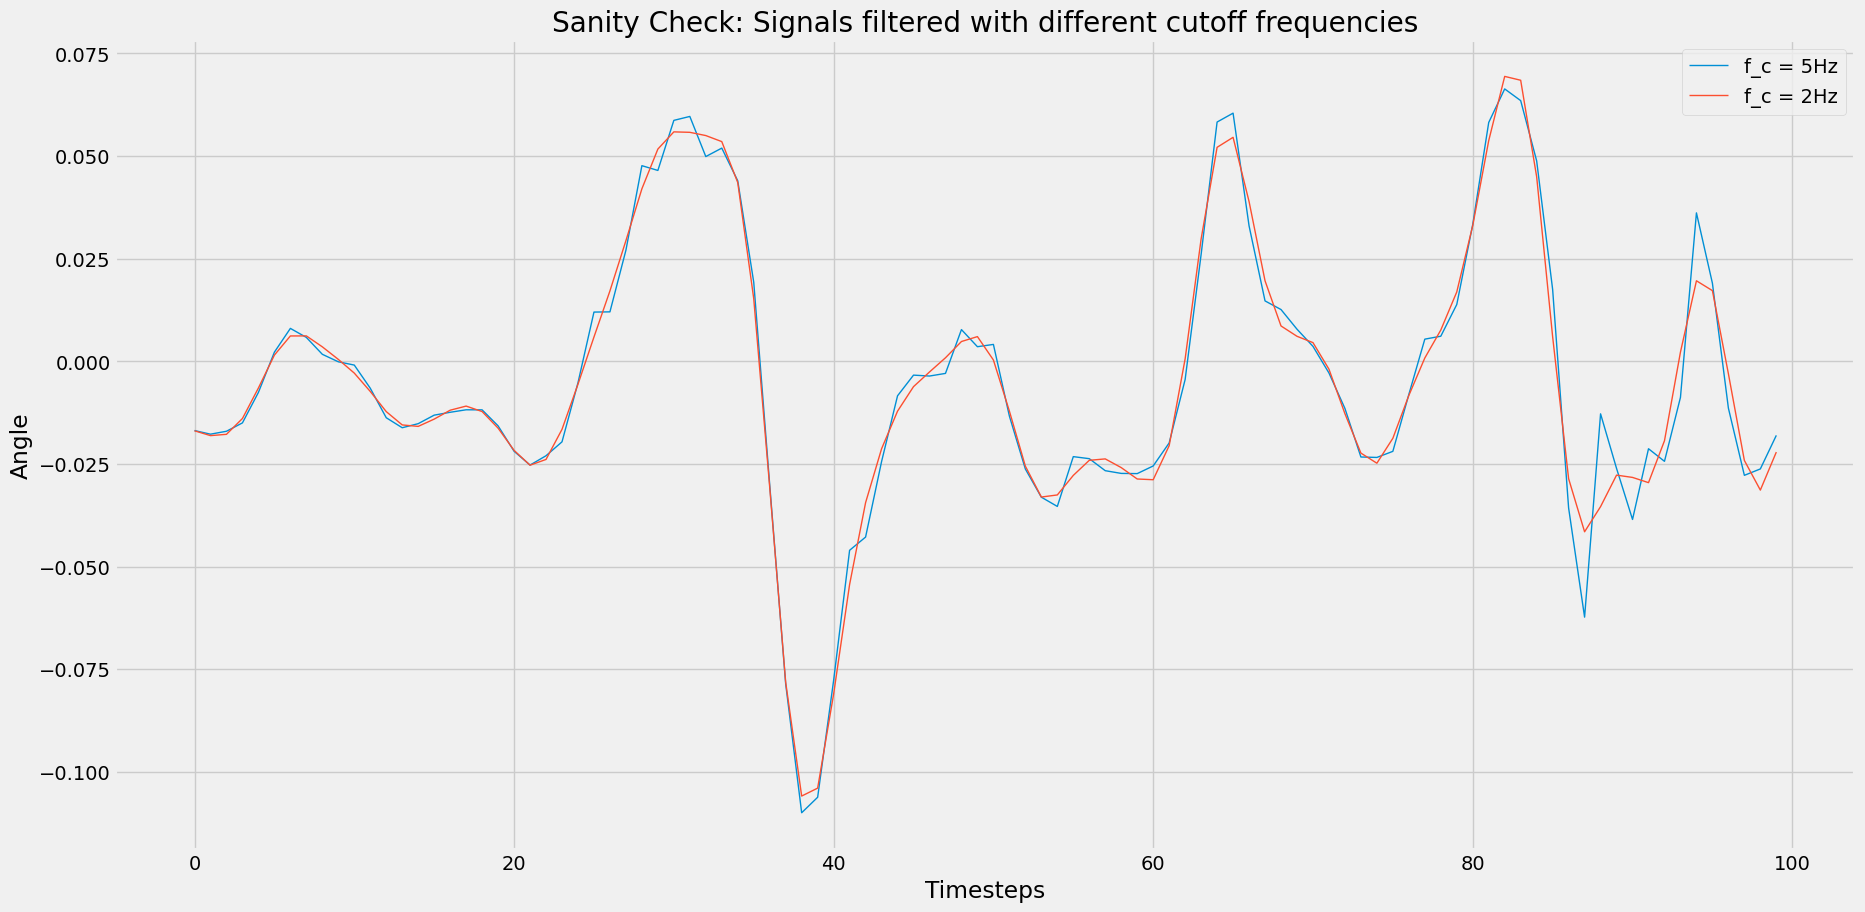

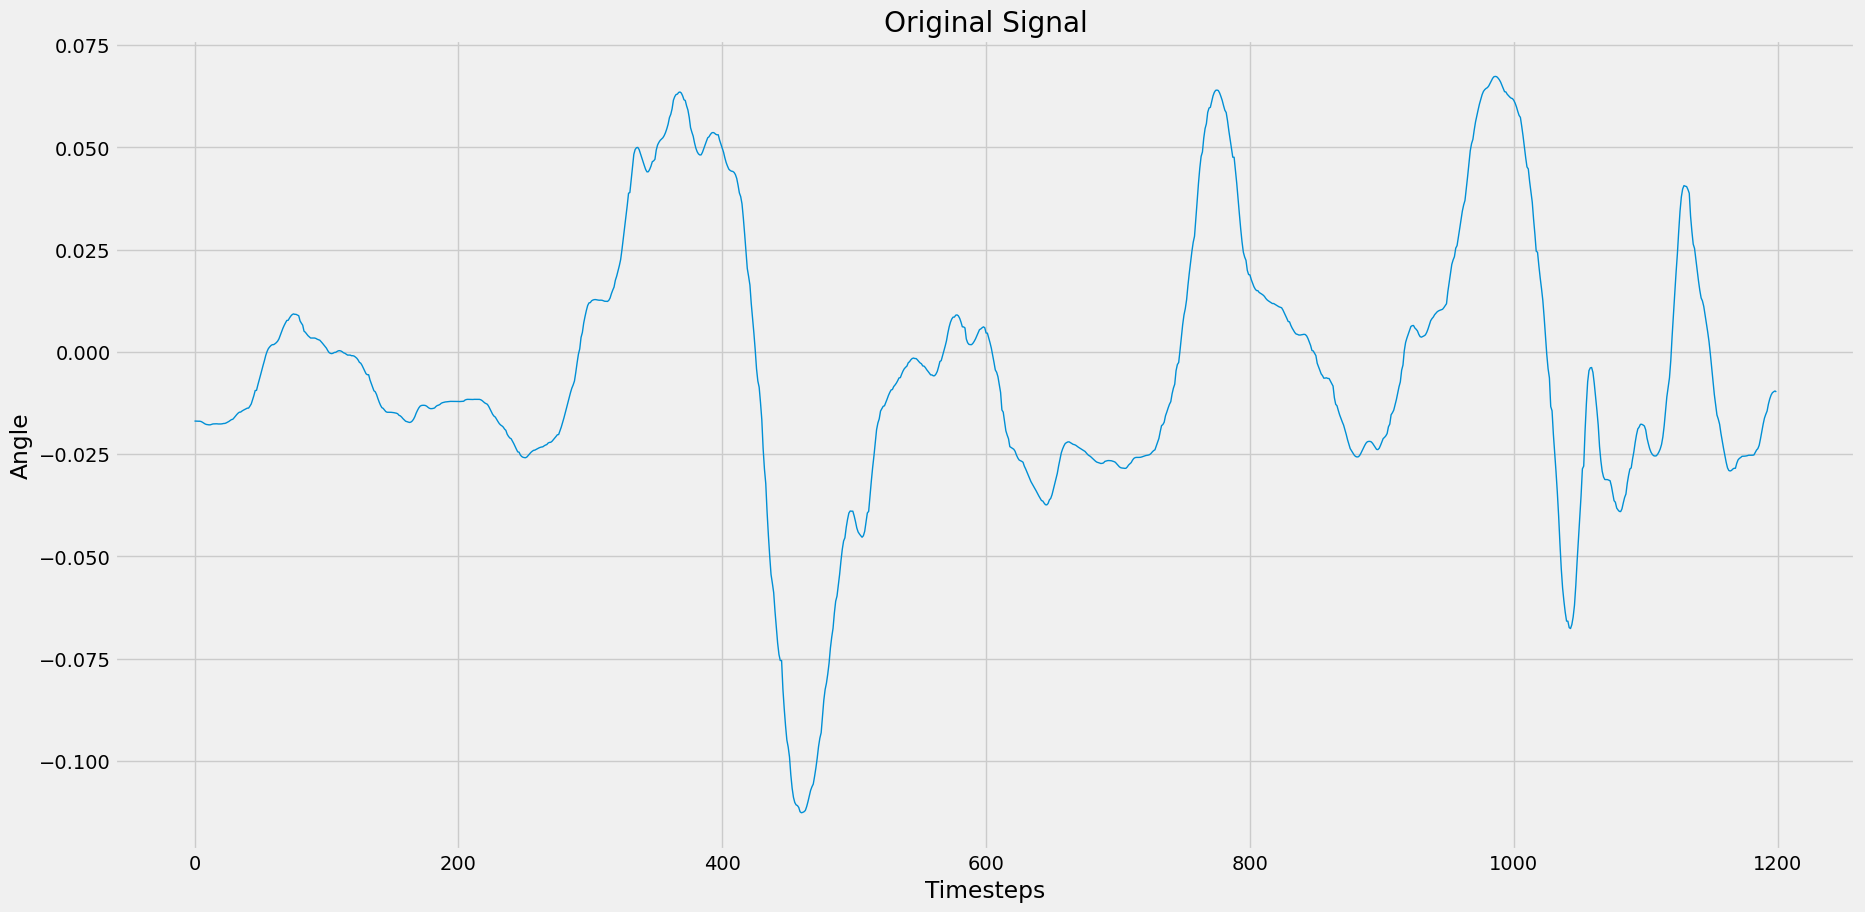

In [15]:
# sanity check
files = os.listdir(data_path)
with open(data_path + files[0], 'rb') as infile:
        d_1 = pickle.load(infile)

# Downsample dictionaries to 10 Hz
d_1_ds = downsample_dictionary(d_1, 10)
d_2_ds = downsample_dictionary(d_1, 10, f_c = 2)

# Plot signals and compare
idx = 100
idx_o = int(idx*120/10)
plt.plot(d_1_ds['position_0'][:idx], label='f_c = 5Hz')
plt.plot(d_2_ds['position_0'][:idx], label = 'f_c = 2Hz')
plt.xlabel('Timesteps')
plt.ylabel('Angle')
plt.title('Sanity Check: Signals filtered with different cutoff frequencies')
plt.legend()
plt.figure()
plt.plot(d_1['position_0'][:idx_o])
plt.xlabel('Timesteps')
plt.ylabel('Angle')
plt.title('Original Signal')


In [16]:
def clean_dict(sig_dict):
    #print(sig_dict.keys(), sig_dict['indices'])
    cleaned_signals = dict()

    for param in sig_dict.keys():
        if (param != 'sample_rate' and param != 'indices'):
            cleaned_signals[param] = []
        elif( param == 'sample_rate'):
            cleaned_signals[param] = sig_dict[param]

    for ind in sig_dict['indices']:
        for param in sig_dict.keys():
            if (param != 'sample_rate' and param != 'indices'):
                cleaned_signals[param].append(sig_dict[param][ind[0]:ind[1]])

    return cleaned_signals


def load_clean_combine_save(data_path = 'Dataset/Converted_120Hz/', sample_rate = None, f_c = None, order = None, save=False):
    """
    Loads all datasets, cleans them using the specified indices from notebook '02_Data_Preparation' and combines them into a single dictionary.
    """
    files = os.listdir(data_path)

    pickle_name = 'full_data_cleaned.pickle'

    in_dicts = []
    cleaned_dicts = []
    full_dict = dict()

    for f in files:
        print(f)
        with open(data_path + f, 'rb') as infile:
            if sample_rate:
                print(f'Downsampling Dictionary to {sample_rate}Hz')
                in_dicts.append(downsample_dictionary(pickle.load(infile), sample_rate, f_c = f_c, order = order))
            else:
                in_dicts.append(pickle.load(infile))

    for d in in_dicts:
        cleaned_dicts.append(clean_dict(d))

    for k in cleaned_dicts[0].keys():
        if (k != 'sample_rate' and k != 'indices'):
            full_dict[k] = cleaned_dicts[0][k]
            for d in cleaned_dicts[1:]:
                
                full_dict[k] += d[k]
        elif k == 'sample_rate':
            full_dict[k] = in_dicts[0][k]

    if save:
        with open(data_path + pickle_name, 'wb') as handle:
            pickle.dump(full_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return full_dict

In [92]:
# Sanity Check
full_dict = load_clean_combine_save(data_path, sample_rate = 10, save = False)
#print(full_dict.keys(), full_dict['sample_rate'])
#plt.plot(full_dict['position_0'][-1])
#plt.plot(-full_dict['orientation.x'][-1])

2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 400.775s. Avg Sample Rate: 120.000/s. Number of samples: 48093.
	After: Duration: 400.700s. Avg Sample Rate: 10.000/s. Number of samples: 4007. Downsampled by factor 0.08

2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 181.692s. Avg Sample

## Split Dataset into Train, Validation & Test
Split all signals in unison based on the sub signals from the Dataset-Cleaning. Exact splitting is not possible, but rough splitting should be good enough.
Splitting it before windowing, ensures that there is no data-leakage.

In [17]:
from operator import length_hint

def train_val_test_split_dict(sig_dict, test_split = 0.2, val_split = 0.2, param = 'position_0', seed = 0):
    """
    Ensures more or less fair split of the dataset into specified sized sets, without dataleakage.
    Creates splits in unison for the complete dataset
    param sig_dict: full_dictionary with all signals
    param __split: split size of the respective split wrt the whole dataset
    param param: parameter to base the split on. Shouldn't make any difference
    param seed: Sets seed for random shuffle of the used indices
    """
    # Calculate the total signal length of unsplit dataset
    tot_sig_len = sum(a.shape[0] for a in sig_dict[param])
    # Ideal length of each split
    n_val = tot_sig_len * val_split
    n_test = tot_sig_len * test_split
    n_train = tot_sig_len - n_test - n_val

    np.random.seed(seed)
    rand_idxs = np.arange(length_hint(sig_dict[param]))
    np.random.shuffle(rand_idxs)

    # Add dataset-blocks to the test and validation set until they are 
    # respectively larger than the ideal lengths n_test & n_val
    i = 0
    test_split_idx = []
    test_size = 0
    
    while (test_size < n_test):
        test_split_idx.append(rand_idxs[i])
        test_size += sig_dict[param][rand_idxs[i]].shape[0]
        i += 1

    val_split_idx = []
    val_size = 0

    while(val_size < n_val):
        val_split_idx.append(rand_idxs[i])
        val_size += sig_dict[param][rand_idxs[i]].shape[0]
        i+=1

    # Rest of signals go to train set
    train_split_idx = []
    train_size = 0
    while (i < rand_idxs.shape[0]):
        train_split_idx.append(rand_idxs[i])
        train_size += sig_dict[param][rand_idxs[i]].shape[0]
        i +=1

    print(f'Train Idxs: {train_split_idx}. \tTotal train length: {train_size}. \n\
Test Idxs: {test_split_idx}. \t\t\t\tTotal test length: {test_size}. \n\
Val Idxs: {val_split_idx}. \t\t\t\t\tTotal val length: {val_size}.')

    # Fill dictionaries with splits
    train_dict = dict()
    val_dict = dict()
    test_dict = dict()

    for k in sig_dict.keys():
        if (k != 'sample_rate' and k != 'indices'):
            train_dict[k] = [sig_dict[k][i] for i in train_split_idx]
            val_dict[k] = [sig_dict[k][i] for i in val_split_idx]
            test_dict[k] = [sig_dict[k][i] for i in test_split_idx]
        elif(k == 'sample_rate'):
            train_dict[k] = sig_dict[k]
            val_dict[k] = sig_dict[k]
            test_dict[k] = sig_dict[k]
    
    return train_dict, val_dict, test_dict

In [ ]:
# Sanity check
#train_dict, val_dict, test_dict = train_val_test_split_dict(full_dict, test_split = 0.2, val_split=0.2)
#plt.plot(train['position_0'][0])
#plt.plot(-train['orientation.x'][0])

## Window Data
Create a function to window the data. Enable window length, target length, stride, etc.

In [18]:
def window_signal(signal, win_len, target_len, stride = 1):
    """
    Creates sub-windows of specified length from given inputs.

    :param signal: input signal 1D as np.array
    :param win_len: length of x portion of window
    :param target_len: length of target window
    :param stride: stride between samples
    :return windows: windowed x portions
    :return targets: windowed targets
    """
    # Calculate Maximum number of windows for a given signal
    sig_len = signal.shape[0]
    n = np.ceil((sig_len - (win_len + target_len)) / stride).astype(int)
    if n < 1:
        return np.array([False]), np.array([False])
    
    # Set up window and target arrays
    windows = np.zeros((n, win_len))
    targets = np.zeros((n, target_len))

    i_s = 0                 # start index window
    i_e = win_len           # end index window
    t_s = i_e               # start index target
    t_e = t_s + target_len  # end index target

    # Create the windows
    for i in range(n):
        windows[i,:] = signal[i_s:i_e]
        targets[i,:] = signal[t_s:t_e]

        i_s += stride
        i_e += stride
        t_s = i_e
        t_e = t_s + target_len

    return [windows, targets]

# Sanity Check
#sig = full_dict['position_0'][0]
#w,t = window_signal(sig, 120, 120, 17)

In [22]:
def create_feature_arrays(sig_dict, feature_params, target_params, win_len=120, target_len = 120, stride = 1, stack = True):
    """
    Creates a Numpy array for every feature, where the data is windowed
    :param sig_dict: Dictionary containing the signals
    :param feature_params: Parameters to keep in feature arrays
    :param target_params: Parameters to keep in target arrays
    :param win_len: Length of input windows
    :param target_lan: Length of target windows
    :param stride: stride between samples of windows
    :param stack: 
        Indicator to stack all signals into numpy arrays or keep them in dictionary
    """
    X_dict = dict()
    target_dict = dict()

    for k in set(feature_params + target_params):
        if (k != 'sample_rate' and k != 'indices'):
            X_dict[k] = []
            target_dict[k] = []
            for sig in sig_dict[k]:
                x, target = window_signal(sig, win_len, target_len, stride)
                if x.any():
                    X_dict[k].append(x)
                    target_dict[k].append(target)

            
            X_dict[k] = np.vstack((X_dict[k]))
            target_dict[k] = np.vstack((target_dict[k]))
    
    if stack:
        features = np.stack([X_dict[p] for p in feature_params], axis = 2)
        targets = np.stack([target_dict[p] for p in target_params], axis = 2)
        print(f'Features shape: {features.shape}. \tTargets shape: {targets.shape}.')
        return features, targets

    return X_dict, target_dict

# Sanity Check
#x,y = create_feature_arrays(full_dict, feature_params = ['position_0', 'position_1', 'orientation.x', 'orientation.y'],target_params = ['position_0', 'position_1'], win_len = 120, target_len=120, stride = 4)
#x.shape, y.shape
#plt.plot(x[30,0,:])
#plt.plot(y[0,0,:])
    

# Putting it all together
Create the desired Data splits from the interpolated (120Hz) data, by splitting and windowing all signals usign the methods above.

In [23]:
data_path = 'Dataset/Converted_120Hz/'
files = os.listdir(data_path)
files

['2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle',
 '2021-11-26-20-05-14_wobble_interpolated_120Hz.pickle',
 '2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-18-38_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-34-38_wobble_interpolated_120Hz.pickle',
 '2022-01-13-17-48-10_wobble_interpolated_120Hz.pickle',
 '2022-01-13-18-02-22_wobble_interpolated_120Hz.pickle',
 '2022-01-20-15-23-37_wobble_interpolated_120Hz.pickle',
 '2022-01-20-15-38-51_wobble_interpolated_120Hz.pickle']

In [24]:
full_dict = load_clean_combine_save(data_path, save = False)
train_dict, val_dict, test_dict = train_val_test_split_dict(full_dict, test_split = 0.15, val_split=0.15, seed = 1)

2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle
2021-11-26-20-05-14_wobble_interpolated_120Hz.pickle
2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
2022-01-13-17-18-38_wobble_interpolated_120Hz.pickle
2022-01-13-17-34-38_wobble_interpolated_120Hz.pickle
2022-01-13-17-48-10_wobble_interpolated_120Hz.pickle
2022-01-13-18-02-22_wobble_interpolated_120Hz.pickle
2022-01-20-15-23-37_wobble_interpolated_120Hz.pickle
2022-01-20-15-38-51_wobble_interpolated_120Hz.pickle
Train Idxs: [32, 82, 38, 19, 123, 27, 36, 56, 39, 74, 91, 95, 40, 59, 66, 90, 23, 34, 116, 108, 4, 103, 15, 104, 41, 52, 26, 43, 24, 97, 118, 93, 49, 21, 70, 3, 111, 30, 120, 47, 92, 8, 81, 60, 0, 113, 57, 22, 61, 63, 7, 119, 13, 86, 94, 96, 87, 68, 122, 14, 29, 28, 11, 84, 18, 101, 20, 50, 25, 6, 109, 71, 76, 1, 16, 64, 79, 5, 75, 9, 72, 12, 107, 37]. 	Total train length: 252250. 
Test Idxs: [48, 114, 73, 106, 45, 31, 67, 46, 98, 83, 115, 33, 100, 117, 102, 121, 2, 89, 110]. 				Total test length: 57600. 
Val Idxs: [

### Sanity Check:
Plot samples from each split and see if window aligns with target

Features shape: (118565, 120, 4). 	Targets shape: (118565, 60, 2).
Features shape: (26010, 120, 4). 	Targets shape: (26010, 60, 2).
Features shape: (27090, 120, 4). 	Targets shape: (27090, 60, 2).


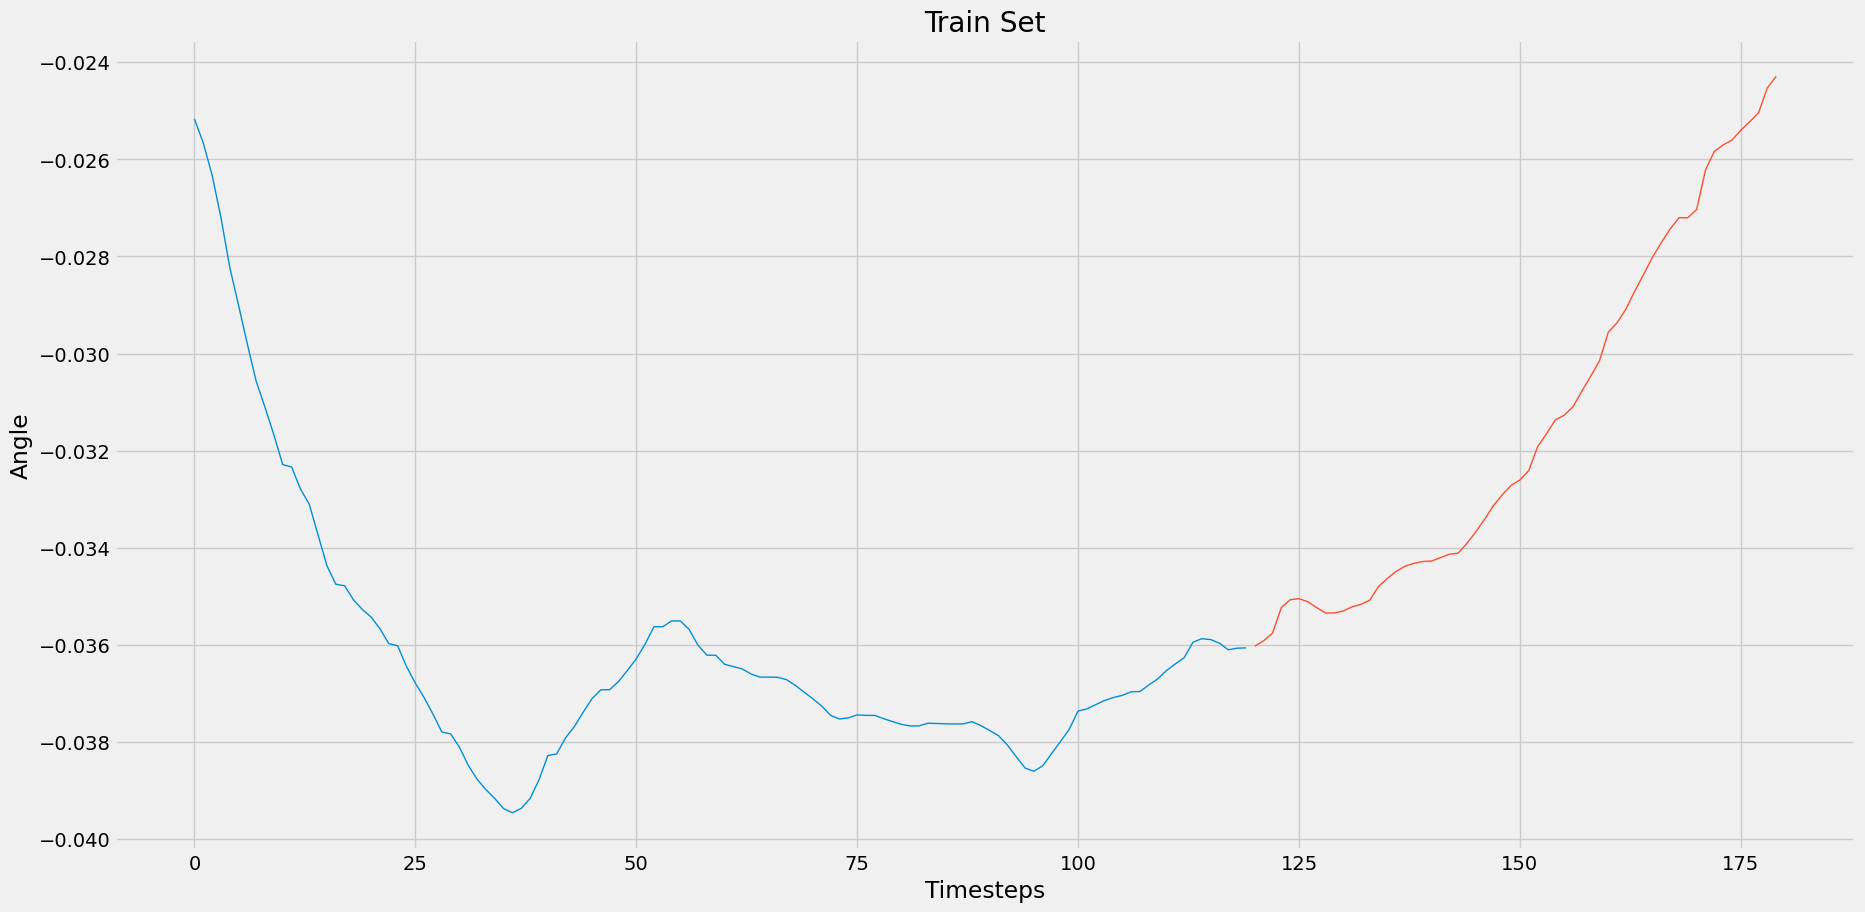

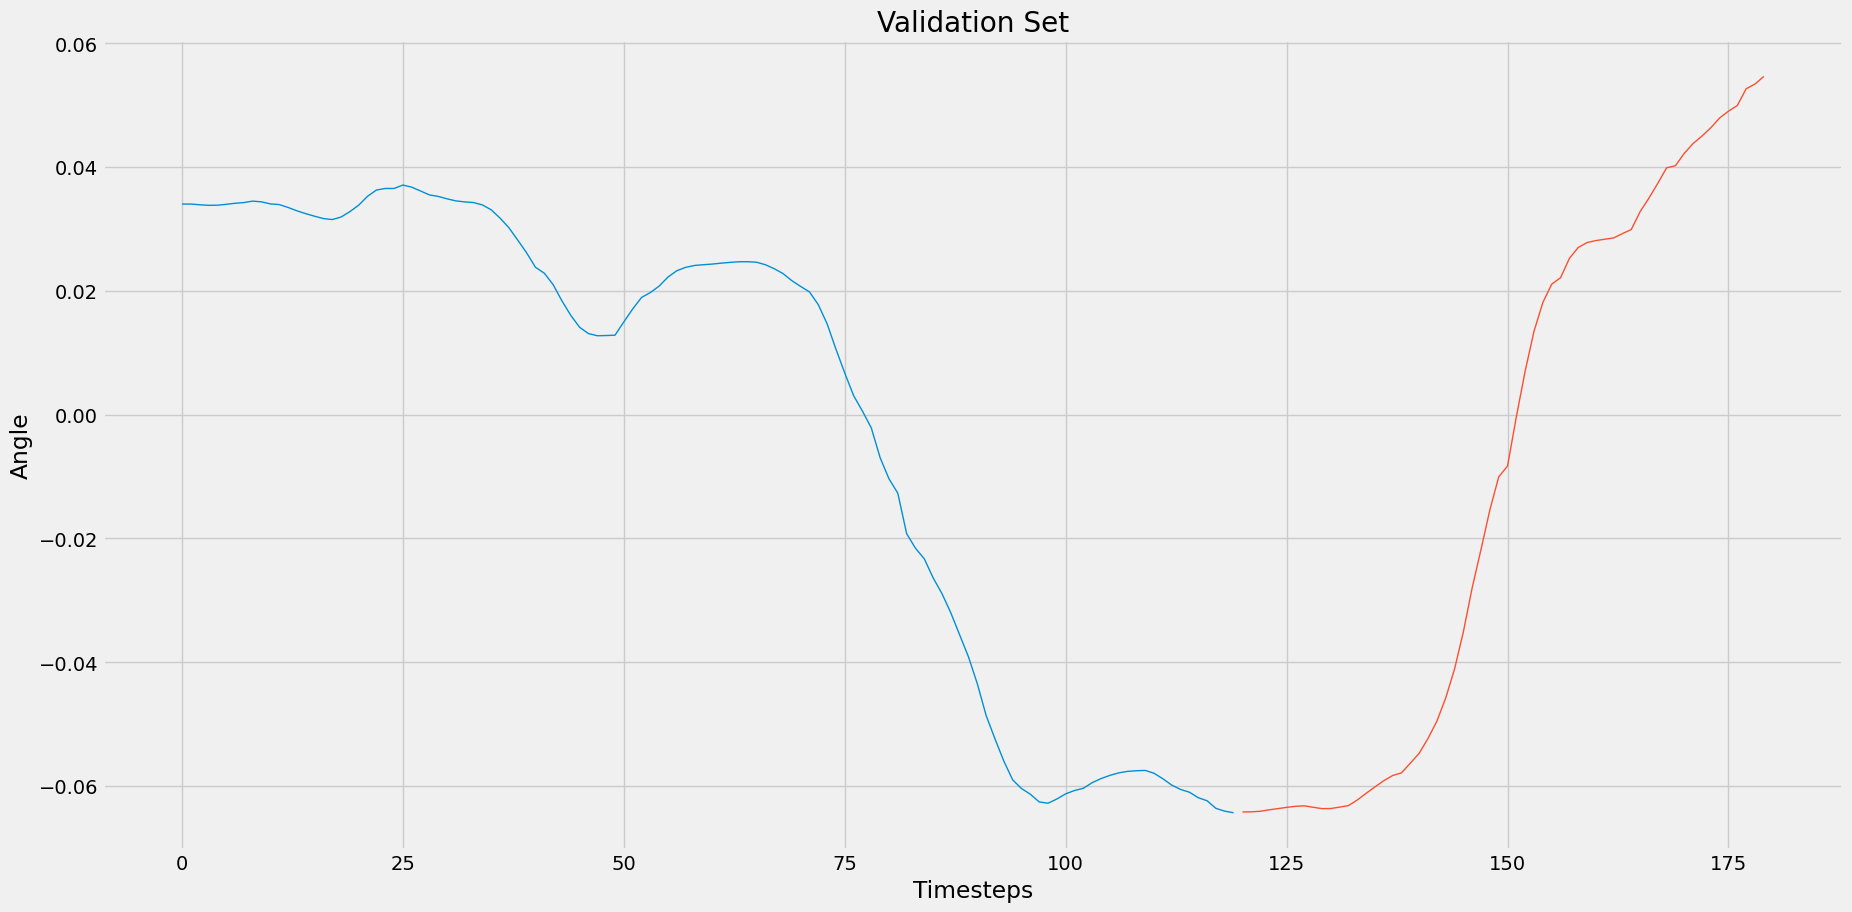

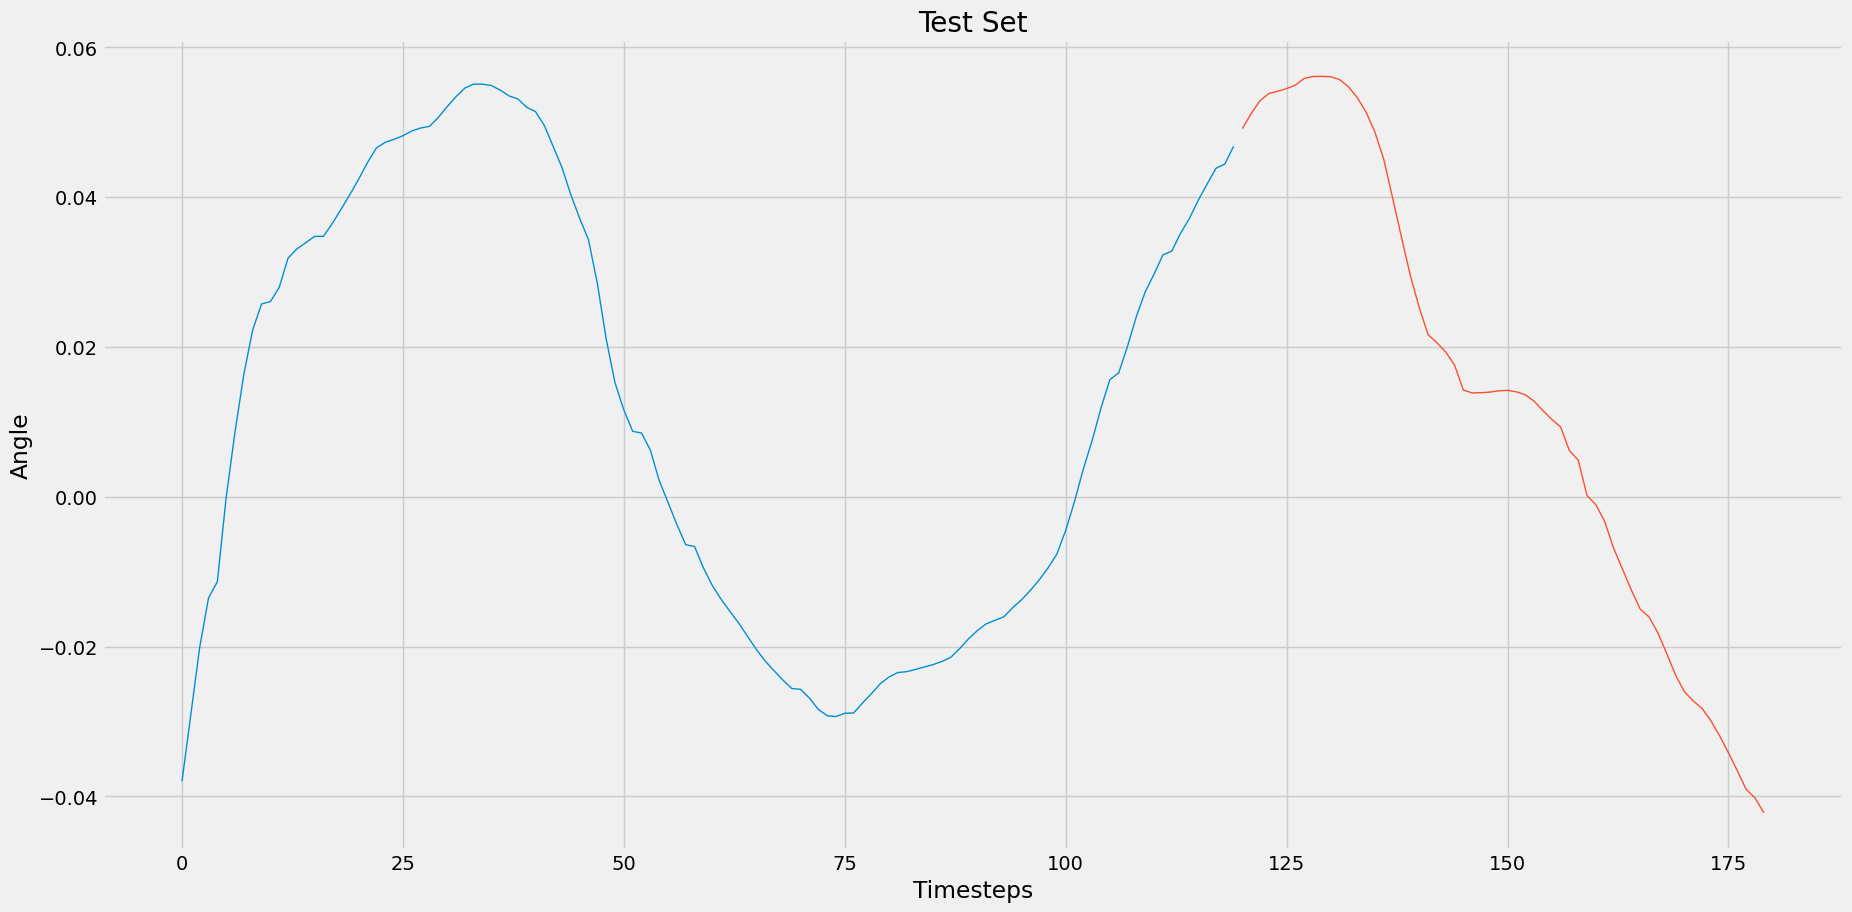

In [31]:
feature_params = ['position_0', 'position_1', 'orientation.x', 'orientation.y']
target_params = ['position_0', 'position_1']
win_len = 120 #240
target_len = 60 #120
stride = 2
stack = True

X_train, y_train = create_feature_arrays(train_dict, feature_params, target_params, win_len, target_len, stride, stack)
X_val, y_val = create_feature_arrays(val_dict, feature_params, target_params, win_len, target_len, stride, stack)
X_test, y_test = create_feature_arrays(test_dict, feature_params, target_params, win_len, target_len, stride, stack)

dataset = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'sample_rate': train_dict['sample_rate']
}


x = np.arange(0, win_len)
y = np.arange(win_len, win_len + target_len)
idx = -50
plt.figure()
plt.xlabel('Timesteps')
plt.ylabel('Angle')
plt.title('Train Set')
plt.plot(x,X_train[idx,:,0])
plt.plot(y,y_train[idx,:,0])

plt.figure()
plt.xlabel('Timesteps')
plt.ylabel('Angle')
plt.title('Validation Set')
plt.plot(x,X_val[idx,:,0])
plt.plot(y,y_val[idx,:,0])

plt.figure()
plt.xlabel('Timesteps')
plt.ylabel('Angle')
plt.title('Test Set')
plt.plot(x,X_test[idx,:,0])
plt.plot(y,y_test[idx,:,0])

# Dataloader Function
There is a seperate Python File which includes the dataloader, so that it can be used in other notebooks. This is merely for testing.

In [98]:
def dataloader(data_path, win_len = 120, target_len = 60, stride = 2, feature_params= ['position_0', 'position_1', 'orientation.x', 'orientation.y', 'orientation.z', 'orientation.w'], target_params=['position_0', 'position_1'], test_split=0.1, val_split=0.1, seed = 3, downsample_rate = 10, stack = True):
    """
    Putting all above functions together to laod the data.plt.plot(np.vstack(a['X_train']))
    :param data_path: path to interpolated dataset
    :param win_len: Signal length of X samples
    :param target_len: Signal length of y samples (targets)
    :param feature_params: features to include in X
    :param target_params: features to include in y (position_0, position_1)
    :param test_split: percentage of data to be used in the test dataset
    :param val_split: percentage of data to be used in the validation dataset
    :param seed: seed for random generator
    :param stack: creates numpy array and throws away dict keys
    """
    full_dict = load_clean_combine_save(data_path, sample_rate = downsample_rate, save = False)
    train_dict, val_dict, test_dict = train_val_test_split_dict(full_dict, test_split = test_split, val_split=val_split, seed = seed)
    
    X_train, y_train = create_feature_arrays(train_dict, feature_params, target_params, win_len, target_len, stride, stack)
    X_val, y_val = create_feature_arrays(val_dict, feature_params, target_params, win_len, target_len, stride, stack)
    X_test, y_test = create_feature_arrays(test_dict, feature_params, target_params, win_len, target_len, stride, stack)

    dataset = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'sample_rate': train_dict['sample_rate']
    }

    return dataset
a = dataloader('Dataset/Converted_120Hz/', stride = 1)



2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 400.775s. Avg Sample Rate: 120.000/s. Number of samples: 48093.
	After: Duration: 400.700s. Avg Sample Rate: 10.000/s. Number of samples: 4007. Downsampled by factor 0.08

2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 181.692s. Avg Sample

2021-11-26-20-14-48_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 400.775s. Avg Sample Rate: 120.000/s. Number of samples: 48093.
	After: Duration: 400.700s. Avg Sample Rate: 10.000/s. Number of samples: 4007. Downsampled by factor 0.08

2021-11-26-20-01-52_wobble_interpolated_120Hz.pickle
Downsampling Dictionary to 10Hz
Converted Signals: ['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'position_0', 'position_1', 'position_0_status', 'position_1_status'].
	Before: Duration: 181.692s. Avg Sample

<Figure size 1440x720 with 0 Axes>

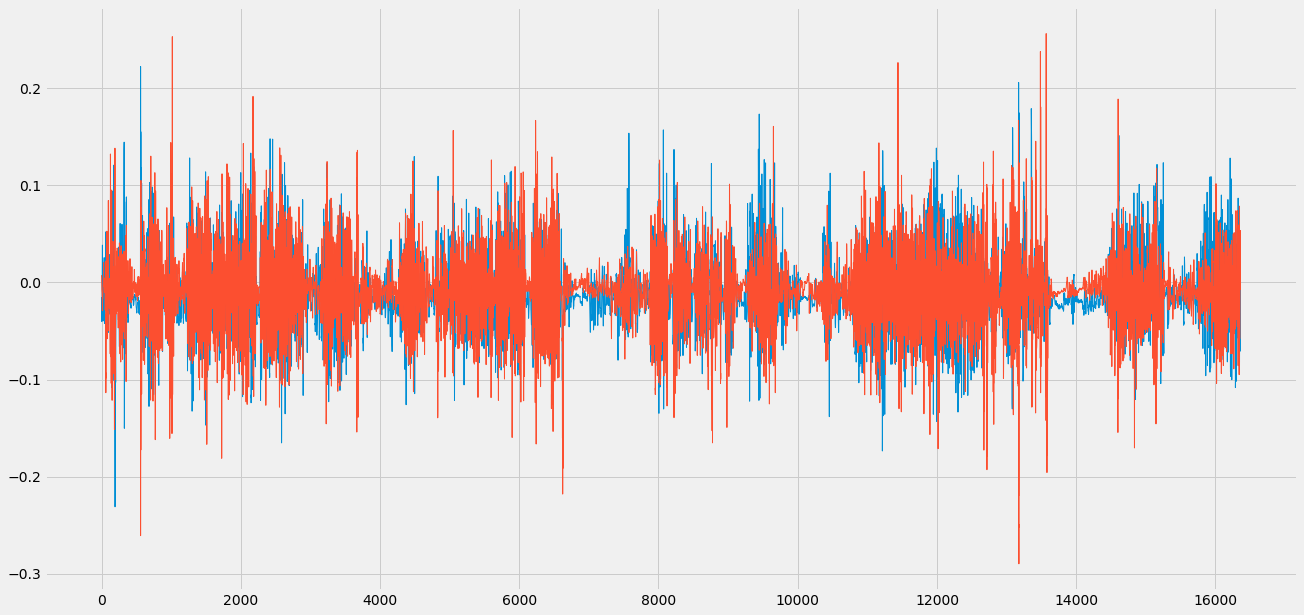

<Figure size 1440x720 with 0 Axes>

In [127]:
a = dataloader('Dataset/Converted_120Hz/', win_len = 20, target_len = 10, stride = 20, feature_params= ['position_0', 'position_1'], downsample_rate = 10)
plt.plot(np.vstack(a['X_train']))
plt.figure()
#b = dataloader('Dataset/Converted_120Hz/', win_len = 10, target_len = 10, stride = 10, feature_params= ['position_0', 'position_1'], downsample_rate = 10)
#plt.plot(np.vstack(b['y_train']))
#c = dataloader('Dataset/Converted_120Hz/', win_len = 120, target_len = 10, stride = 120, feature_params= ['position_0', 'position_1'], downsample_rate = None)
#plt.figure()
#plt.plot(np.vstack(c['X_train']))

In [13]:
from dataloader import dataloader

a = dataloader('Dataset/Converted_120Hz/')

Train Idxs: [36, 55, 99, 81, 77, 40, 48, 58, 80, 23, 34, 70, 93, 100, 74, 15, 90, 41, 51, 45, 98, 52, 26, 105, 43, 66, 24, 4, 83, 96, 49, 21, 3, 30, 47, 82, 8, 60, 0, 97, 57, 22, 61, 63, 7, 103, 13, 68, 92, 14, 29, 28, 11, 84, 18, 20, 50, 25, 6, 71, 76, 1, 16, 64, 79, 5, 75, 9, 72, 12, 37]. 	Total train length: 190660. 
Test Idxs: [67, 35, 73, 62, 39, 53, 56, 88, 31, 59, 101, 78, 94, 65, 33, 91]. 				Total test length: 42150. 
Val Idxs: [38, 95, 17, 102, 89, 85, 69, 46, 44, 42, 86, 87, 54, 106, 10, 2, 32, 104, 19, 27]. 					Total val length: 41200.
Features shape: (89120, 120, 6). 	Targets shape: (89120, 60, 2).
Features shape: (19070, 120, 6). 	Targets shape: (19070, 60, 2).
Features shape: (19725, 120, 6). 	Targets shape: (19725, 60, 2).
